In [ ]:
import torch

In [ ]:
import torch.nn as nn

In [ ]:
import torch.optim as optim

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
import torchvision.transforms as transforms

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image

The Python Imaging Library (PIL), now maintained as Pillow, is a library for image processing and manipulation in Python. It is widely used for handling image data in machine learning, computer vision, and other domains. Here's why PIL (Pillow) is important:


1.   **Image Loading and Saving:** PIL provides the ability to open, read, and save images in various formats, such as:

  * JPEG, PNG, BMP, GIF, TIFF, and more.


2.   **Image Format Conversion:** PIL supports converting images between different formats. For example, you can convert a PNG image to a JPEG or vice versa.

1.   **Image Resizing and Cropping:** PIL makes it easy to resize, crop, and reshape images, which is essential in machine learning tasks where input images need to be standardized to specific dimensions.
2.   **Image Augmentation**

1.   **Image Filtering**
2.   **Access and Modify Pixel Data**

In [ ]:
import os

In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# # Define a simple CNN for image deraining
# class DerainNet(nn.Module): # What it does: Defines a new class DerainNet that inherits from PyTorch's nn.Module. This is the base class for all neural networks in PyTorch.
#     def __init__(self): # Initializes the class.
#         super(DerainNet, self).__init__() # Calls the __init__ method of the parent nn.Module class using super(), which is required for proper initialization.

#         # Defines the first block of layers, which is responsible for extracting features from the input image.
#         # A 2D convolutional layer with: 3 input channels (for RGB images), 64 output channels (feature maps), Kernel size of 3x3,
#         # Padding of 1 ensures the spatial size of the output remains the same as the input.
#         # Applies the ReLU activation function to introduce non-linearity.
#         self.block1 = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#         )

#         # Defines the second block of layers, which reconstructs the derained image from the features extracted by Block 1.
#         self.block2 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 3, kernel_size=3, padding=1)
#         )

#     def forward(self, x): # Defines the forward pass for the model. This specifies how the input data flows through the layers.
#         x = self.block1(x) # Passes the input x through the first block (block1) to extract features.
#         x = self.block2(x) # Passes the output of block1 through the second block (block2) to reconstruct the derained image.
#         return x # Returns the final output (the derained image).

In [ ]:
# Define a simple CNN for image deraining
class DerainNet(nn.Module):
    def __init__(self):
        super(DerainNet, self).__init__()
        self.CONV_S = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.CONV = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.ACTIVATION = nn.ReLU()
        self.BATCH_NORM = nn.BatchNorm2d(64)
        self.CONV_F = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    def forward(self, x):
        x = self.CONV_S(x)
        x = self.BATCH_NORM(x)
        x = self.ACTIVATION(x)
        x = self.CONV(x)
        x = self.ACTIVATION(x)
        x = self.CONV_F(x)
        return x

In [ ]:
model = DerainNet().to(device) # Creates an instance of the DerainNet model you defined earlier. Moves the model and its parameters to the specified device, either GPU (cuda) or CPU.
xx = torch.randn(1, 3, 256, 256).to(device) # Creates a random tensor of shape (1, 3, 256, 256)
out = model(xx) # Passes the input tensor xx through the DerainNet model.
print(out.shape)

torch.Size([1, 3, 256, 256])


In [ ]:
from google.colab import drive # The drive module provides tools to interact with your Google Drive storage directly within a Google Colab notebook.
drive.mount('/content/gdrive/') # Mounts your Google Drive to the Colab environment at the directory path /content/gdrive/

Mounted at /content/gdrive/


In [ ]:
# Load dataset
# Prepare a folder with rainy images and corresponding ground truth clean images
rainy_images_path = '/content/gdrive/MyDrive/Colab Notebooks/rainy_image/'  # Replace with your dataset path
clean_images_path = '/content/gdrive/MyDrive/Colab Notebooks/clean_image/'  # Replace with your dataset path

In [ ]:
class DerainDataset(Dataset):
    def __init__(self, rainy_dir, clean_dir, transform=None):
        self.rainy_dir = rainy_dir
        self.clean_dir = clean_dir


        self.rainy_images = sorted(os.listdir(rainy_dir))
        self.clean_images = sorted(os.listdir(clean_dir))


        self.transform = transform

    def __len__(self):
        return len(self.rainy_images)

    def __getitem__(self, idx):
        # Constructs the full file paths for the rainy and clean images using their directory paths and filenames.
        rainy_path = os.path.join(self.rainy_dir, self.rainy_images[idx])
        clean_path = os.path.join(self.clean_dir, self.clean_images[idx])


        rainy_image = Image.open(rainy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')

        # Applies the transformation (if provided) to both the rainy and clean images.
        if self.transform:
            rainy_image = self.transform(rainy_image)
            clean_image = self.transform(clean_image)

        # Returns the processed rainy and clean image pair as tensors
        return rainy_image, clean_image

In [ ]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [ ]:

dataset = DerainDataset(rainy_images_path, clean_images_path, transform)
# Wraps the dataset into a PyTorch DataLoader to handle batch processing, shuffling, and parallel data loading.
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:

model = DerainNet().to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

def train_model(model, data_loader, criterion, optimizer, num_epochs=10):

    model.train()

    loss_history = []

    for epoch in range(num_epochs):

        epoch_loss = 0

        for rainy, clean in data_loader:
            rainy = rainy.to(device)
            clean = clean.to(device)


            optimizer.zero_grad()

            outputs = model(rainy)

            loss = criterion(outputs, clean)

            loss.backward()
            # Updates the model’s parameters using the gradients computed during backpropagation and the optimization algorithm
            optimizer.step()


            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader)

        loss_history.append(avg_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(data_loader):.4f}")
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epoch') # Adds a label to the x-axis of the plot, which in this case is "Epoch".
    plt.ylabel('Loss') # Adds a label to the y-axis of the plot, which in this case is "Loss".
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

Epoch [1/10], Loss: 0.0237
Epoch [2/10], Loss: 0.0212
Epoch [3/10], Loss: 0.0270
Epoch [4/10], Loss: 0.0200
Epoch [5/10], Loss: 0.0220
Epoch [6/10], Loss: 0.0231
Epoch [7/10], Loss: 0.0228
Epoch [8/10], Loss: 0.0226
Epoch [9/10], Loss: 0.0206
Epoch [10/10], Loss: 0.0194


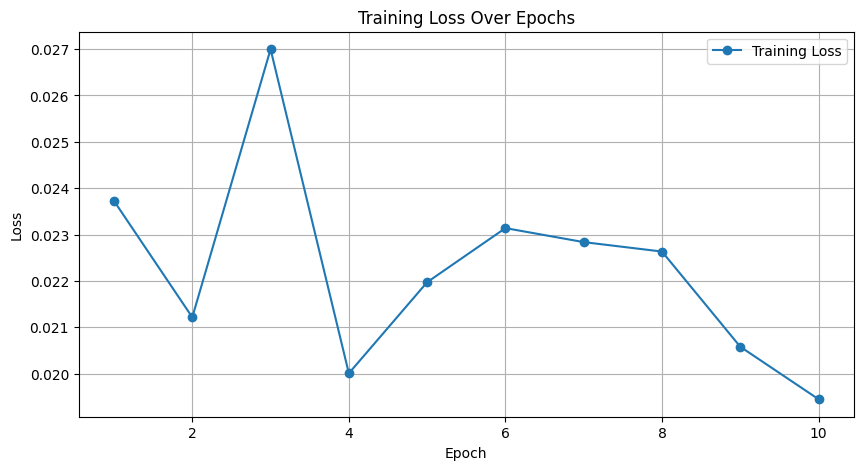

In [ ]:

train_model(model, data_loader, criterion, optimizer, num_epochs=10)

In [ ]:
# Test the model on a sample image
def test_model(model, rainy_image_path):
    model.eval() # Switches the model to evaluation mode.
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    rainy_image = Image.open(rainy_image_path).convert('RGB')


    rainy_tensor = transform(rainy_image).unsqueeze(0).to(device)

   with torch.no_grad():
        output = model(rainy_tensor).squeeze(0).cpu()
    output_image = transforms.ToPILImage()(output.clamp(0, 1))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Rainy Image")
    plt.imshow(rainy_image)
    plt.subplot(1, 2, 2)
    plt.title("Derained Image")
    plt.imshow(output_image)
    plt.show()
    return output_image, rainy_image

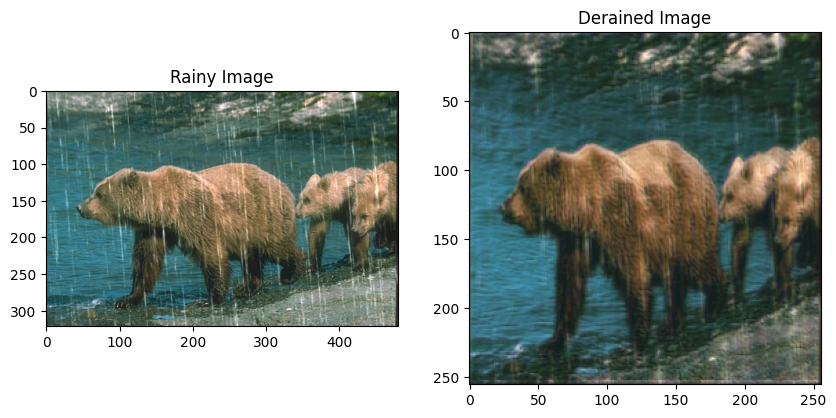

In [ ]:

sample_rainy_image_path = '/content/gdrive/MyDrive/Colab Notebooks/rainy_image/1.png'
o,r = test_model(model, sample_rainy_image_path)

In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [ ]:
def calculate_psnr(image1, image2):

    image1 = np.array(image1, dtype=np.float32)
    image2 = np.array(image2, dtype=np.float32)


    mse = np.mean((image1 - image2) ** 2)

    if mse == 0:
        return float('inf')


    max_pixel = 255.0
    psnr_value = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr_value

In [ ]:
def calculate_ssim(image1, image2):

    return ssim(image1, image2, multichannel=True, win_size=3, data_range=255)

In [ ]:

sample_clean_image_path =  '/content/gdrive/MyDrive/Colab Notebooks/clean_image/1.png'
image2 = cv2.imread(sample_rainy_image_path)
image1 = np.array(o)
image1 = cv2.resize(image1, (256, 256))
image2 = np.array(image2)
image2 = cv2.resize(image2, (256, 256))

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

psnr_value = calculate_psnr(image1, image2)
print(f"PSNR: {psnr_value:.2f} dB")


ssim_value = calculate_ssim(image1, image2)
print(f"SSIM: {ssim_value:.4f}")

PSNR: 15.36 dB
SSIM: 0.0596
